# 4.利用训练过程解释

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 直接对比可视化图片

1. 指定目录读取Trail的路径

In [2]:
tune_result_dir = "tune/results/max_epochs_tune/"
figure_mode = "pseudotime" # 展示图片的格式 arrow, stream, pseudotime

In [3]:
import os
import re
import pandas as pd

df = pd.DataFrame()

# trail文件夹列表
trail_dir_list = [os.path.join(tune_result_dir, file) for file in os.listdir(tune_result_dir) if os.path.isdir(os.path.join(tune_result_dir, file))]
df["trail_dir"] = trail_dir_list

# 从trail文件夹名称提取使用正则表达式参数和值
pattern = r"\d+_([^\d]+)=([^=_]+)"
param_str_list = []
for trail_dir in trail_dir_list:
    match = re.findall(pattern, trail_dir)[0]
    param_name = match[0]
    param_value = match[1]
    param_str = param_name+"="+param_value
    param_str_list.append(param_str)
df["param_str"] = param_str_list

# 解析参数对
def get_param_value(row):
    param_pair_dict = row["param_str"].split(",")
    for param_pair in param_pair_dict:
        param_pair_item = param_pair.split("=")
        row[param_pair_item[0]] = param_pair_item[1]
    return row
df = df.apply(lambda x:get_param_value(x), axis=1)

df

,trail_dir,param_str,max_epochs
0,tune/results/max_epochs_tune/train_velovgi_60a...,max_epochs=10,10
1,tune/results/max_epochs_tune/train_velovgi_60a...,max_epochs=20,20
2,tune/results/max_epochs_tune/train_velovgi_60a...,max_epochs=30,30


In [4]:
df["max_epochs"] = df["max_epochs"].astype("int")

2. 查看图片

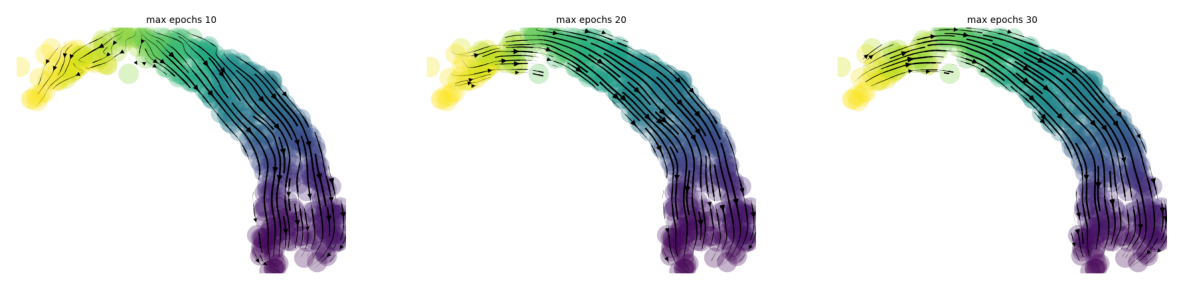

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

img_path_list = list(df["trail_dir"].apply(lambda x: "%s/figures/scvelo_%s.png"%(x, figure_mode)))
n = len(img_path_list)
fig, ax = plt.subplots(1, n, figsize=(5*n,  4))

for i in range(n):
    img_path = img_path_list[i]
    image = Image.open(img_path)
    ax[i].imshow(image)
    ax[i].axis("off")# 不显示坐标轴

plt.show()

## 2. 读取模型数据、准备对比更多内容

In [10]:
batch_key = "stage" # TODO: 批次key
cluster_key = "celltype" # TODO: 细胞类型key
pseudotime_key = "velocity_pseudotime"

In [7]:
model_path_list = list(df["trail_dir"].apply(lambda x: "%s/model"%x))
adata_path_list = list(df["trail_dir"].apply(lambda x: "%s/adata"%x))

epoch_list = df["max_epochs"]
model_list = []
adata_list = []

for adata_path, model_path in zip(adata_path_list, model_path_list):
    adata = velovgi.tl.read_adata(adata_path)
    model = velovgi.tl.VELOVGI.load(model_path, adata=adata, use_gpu=True) # TODO: 需要根据gpu进行调换
    adata_list.append(adata)
    model_list.append(model)

adata_list, model_list

load tune/results/max_epochs_tune/train_velovgi_60adc_00000_0_max_epochs=10_2023-06-10_11-10-39/adata/adata.h5ad
load tune/results/max_epochs_tune/train_velovgi_60adc_00000_0_max_epochs=10_2023-06-10_11-10-39/adata/sample_recover.pkl
INFO     File                                                                                                      
         tune/results/max_epochs_tune/train_velovgi_60adc_00000_0_max_epochs=10_2023-06-10_11-10-39/model/model.pt 
         already downloaded                                                                                        
load tune/results/max_epochs_tune/train_velovgi_60adc_00001_1_max_epochs=20_2023-06-10_11-10-45/adata/adata.h5ad
load tune/results/max_epochs_tune/train_velovgi_60adc_00001_1_max_epochs=20_2023-06-10_11-10-45/adata/sample_recover.pkl
INFO     File                                                                                                      
         tune/results/max_epochs_tune/train_velovgi_60adc_00001_1_ma

VELOVGI Model with the following params: 
n_hidden: 256, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained

VELOVGI Model with the following params: 
n_hidden: 256, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained

VELOVGI Model with the following params: 
n_hidden: 256, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained

([AnnData object with n_obs × n_vars = 500 × 2000
      obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
      var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
      uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover', '_scvi_uuid', '_scvi_manager_uuid'
      obsm: 'X_pca', 'X_umap', 'velocity_umap'
      layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
      obsp: 'connectivities', 'distances',
  AnnData object with n_obs × n_vars = 500 × 2000
      obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velo

## 3. 对比特征基因

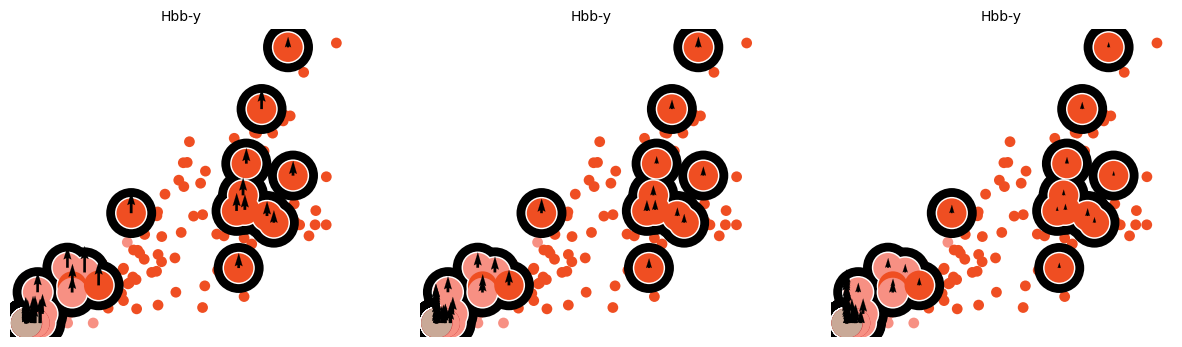

In [9]:
import math
import numpy as np
from scvelo.pl.utils import default_size

gene_list = ["Hbb-y"]

np.random.seed(0)
cell_num = adata.shape[0]
size = default_size(adata)*math.log(adata.shape[0]) # 箭头的缩放比例
index_list = np.random.choice(np.arange(cell_num), size=int(cell_num*0.1), replace=False) # 部分细胞展示速率图


for gene in gene_list:
    item_figsize = (5, 4) # 单张图的figsize
    fig, ax = velovgi.pl.calc_fig(n, item_figsize=item_figsize) # 计算尺寸
    for i in range(n):
        name = epoch_list[i]
        adata = adata_list[i]
        tmp_adata = adata[index_list, gene_list]
        velovgi.pl.draw_velocity_gene(tmp_adata, adata, gene, cluster_key=cluster_key, size=size, ax=ax[i])

## 4. 对比隐变量

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_latent_umap', embedded velocity vectors (adata.obsm)


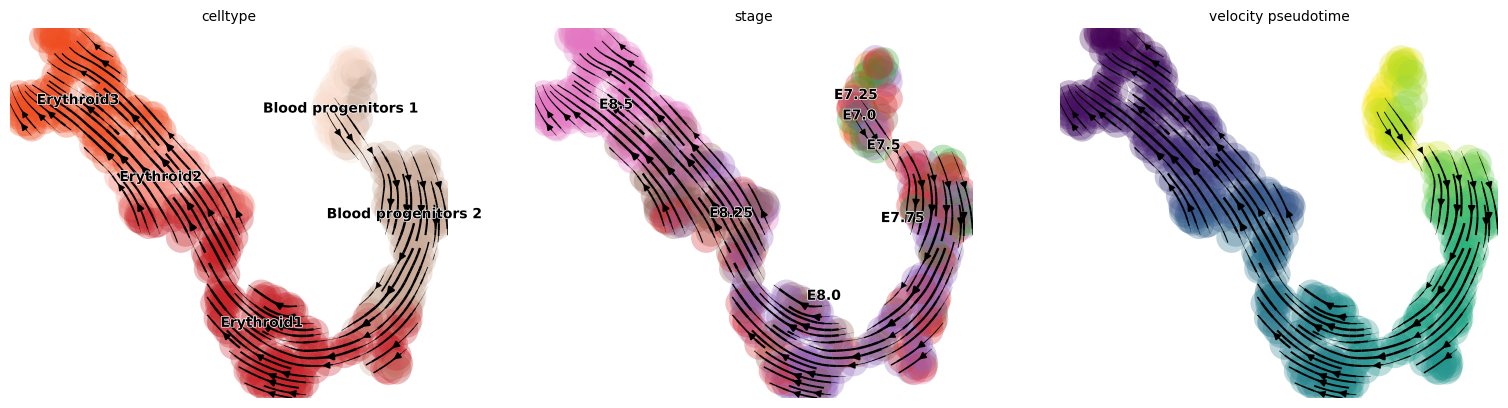

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


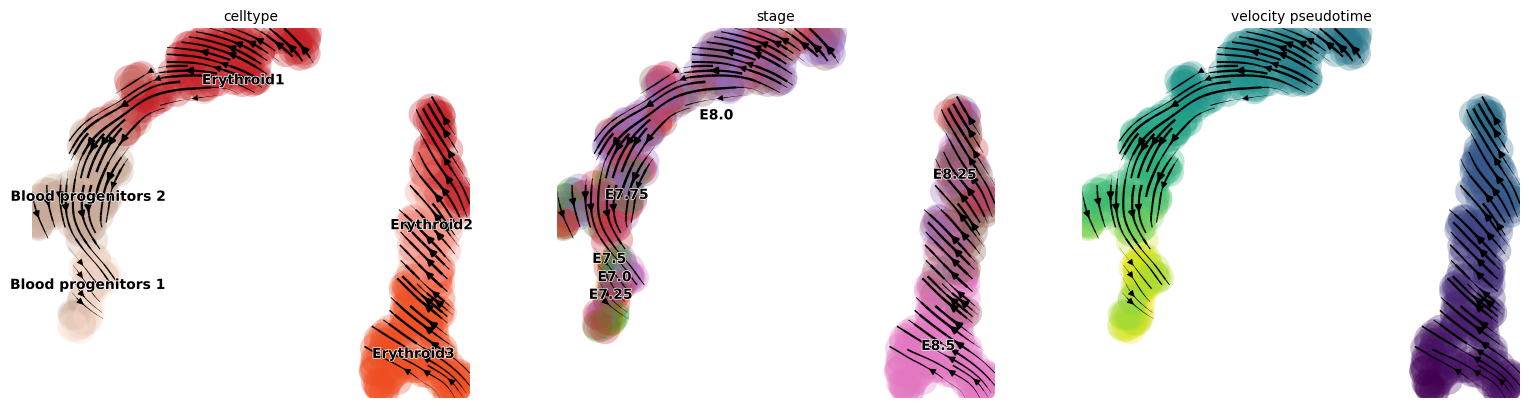

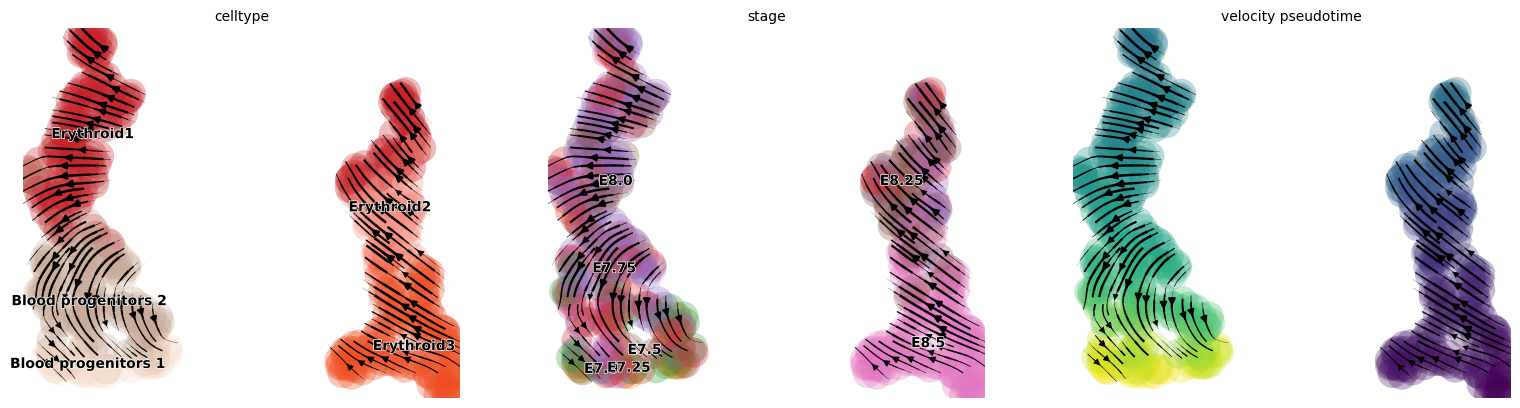

In [11]:
latent_umap_key = "X_latent_umap"

for model in model_list:
    velovgi.tl.get_latent_umap(adata, model, latent_umap_key=latent_umap_key)
    scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key, pseudotime_key], basis=latent_umap_key, colorbar=False)